# NLP Project: Modeelo capaz de generar Tweets con estilo de autor (Gustavo Petro)


# 1. Entendimiento del Negocio

## 1.1 Objetivo del Negocio y del Proyecto

* **Objetivo general:** Construir un sistema capaz de generar *tweets* con el estilo del autor (**Gustavo Petro**) dado un tema o *prompt*, para usos de investigación lingüística, generación de contenido automático controlado y análisis de estilo.
* **Valor de negocio:** Creación de herramientas para simulación de tono, apoyo en redacción de comunicados en tono similar (con avisos éticos), análisis de consistencia discursiva y enseñanza de técnicas de NLP aplicadas a textos políticos.
* **Nota ética:** El uso de modelos que imitan a personas públicas debe incluir rotulado claro (p. ej. "generado por IA, no es real"), cumplir licencias y considerar riesgos de desinformación.



## 1.2 Descripción del Conjunto de Textos Seleccionado

* **Dataset:** `jhonparra18/petro-tweets` en Hugging Face.
* **Idioma:** Español.
* **Formato:** Parquet.
* **Tamaño:** $\approx 19.8k$ *tweets* (split *train*, 19.8k filas).
* **Columnas clave:** `Date`, `User` (`petrogustavo`), `Tweet`.
* **Licencia:** MIT (ver página del dataset).



## 1.3 Proceso de Carga u Obtención de Textos

* Usaremos la **API de Hugging Face / datasets** o `pandas.read_parquet("hf://...")` para Colab, asegurando la trazabilidad de los datos.

# 2. Entendimiento y Preparación del Conjunto de Texto

## 2.1 Analisis corpus

El corpus sera expuesto a un analisis excploratorio de los datos y descriptivo tanto en los tweets en si como en la dimension del tiempo para obtener un mejor entendimiento del comportamiento del autor, y de la naturaleza de los tweets

## 2.2 Visualizaciones Sugeridas y Uso de Lematización/TF-IDF

Para enriquecer el **análisis descriptivo** (Fase 2) y la visualización de palabras clave, utilizaremos la representación TF-IDF y el texto lematizado para:

* ***Top-25* palabras** (basado en la **frecuencia** simple).
* **Visualización de Palabras Clave (Uso TF-IDF Lematizado):** Se generará un gráfico de barras usando el **score TF-IDF acumulado** de los **términos lematizados** (palabras raíz) para identificar los conceptos más **distintivos** del corpus.

## 2.3 Preprocesamiento en NLP (Resumen de *Pipelines*)

Se definen **tres *pipelines* distintos** para alimentar las diferentes fases del proyecto, según los requerimientos del modelo:

| Pipeline | Propósito | Limpieza |
| :--- | :--- | :--- |
| **Lematizado Extenso** | **Análisis de Contenido** y Detección de Temas. | Elimina: Puntuación, *Stopwords*, URLs, Menciones, *Hashtags*. Convierte palabras a su **lema** (raíz). |
| **Markov** | **Generación de Texto *Baseline***. | Limpieza: URLs y Menciones. Mantiene: Formato, puntuación, mayúsculas, conjugaciones y *emojis*. |
| **LSTM (Neuronal)** | **Generación de Texto Avanzada**. | Limpieza: URLs y Menciones. **Normaliza acentos** (`unidecode`). Mantiene: Estilo, puntuación, mayúsculas y *emojis*. |

## Importaciones

In [ ]:
# --- Instalación de librerías necesarias ---
!pip install datasets pandas scikit-learn nltk tensorflow matplotlib seaborn -q
!pip install datasets spacy unidecode
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 16.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# --- Importaciones base ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from datasets import load_dataset
import re
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
from unidecode import unidecode
import spacy
import random
from collections import defaultdict
from google.colab import drive
import os

## Cargar y preparar el dataset base

In [ ]:

dataset = load_dataset("jhonparra18/petro-tweets")
df = pd.DataFrame(dataset['train'])
df_base = pd.DataFrame(dataset['train'])[['Date', 'User', 'Tweet']]

print("Columnas:", df_base.columns.tolist())
print("Número de tweets:", len(df_base))
print("Ejemplo de texto:")
print(df_base['Tweet'].iloc[0])


Columnas: ['Date', 'User', 'Tweet']
Número de tweets: 19790
Ejemplo de texto:
La prensa engolosinada con el dinero público que a manos llenas le entrega Peñalosa, no solo no registra el hecho que se desplomó en 1.6 millones los viales diarios en el sistema de transporte público, sino algo peor:

Que en Bogotá la mortalidad infantil aumentó respecto al 2015


## **Analisis exploratiorio y Descriptivo**

In [ ]:
df_base.head()

,Date,User,Tweet
0,2019-12-30 21:54:11+00:00,petrogustavo,La prensa engolosinada con el dinero público q...
1,2019-12-30 21:41:18+00:00,petrogustavo,Se vuelve ley el regalo de fin de año a los ma...
2,2019-12-30 21:34:09+00:00,petrogustavo,"Continua la danza macabra, la orgía de sangre."
3,2019-12-30 18:24:12+00:00,petrogustavo,El gobierno progresista de España a punto de c...
4,2019-12-30 18:21:35+00:00,petrogustavo,El gobierno progresista de España a punto de c...


### **Totalidad de tweets**

In [ ]:
print("Total de tweets en el corpus:", len(df_base))

Total de tweets en el corpus 19790


In [ ]:
def limpiar_para_analisis(texto):
    texto = texto.lower()
    texto = re.sub(r"https\S+|www\S+|@\w+|#\w+", "", texto)
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    return texto

df_analisis = df_base.copy()
df_analisis['clean_tweet'] = df_analisis['Tweet'].apply(limpiar_para_analisis)

### **Existencia de Duplicados**

In [ ]:
df_analisis.duplicated(subset=['clean_tweet']).sum()

np.int64(271)

### **Existencia de NA**

In [ ]:
df_analisis['clean_tweet'].isna().sum()

np.int64(0)

### **Promedio de longitud en los tweets**

In [ ]:
print("Promedio de longitud de caracteres los tweets en el corpus", df_analisis['clean_tweet'].apply(len).mean())

Promedio de longitud de caracteres los tweets en el corpus 132.18403233956545


### **Promedio de palabras diferentes por tweet en el corpus:**

In [ ]:
print("Promedio de palabras diferentes por tweet en el corpus", df_analisis['clean_tweet'].apply(lambda x: len(x.split())).mean())

Promedio de palabras diferentes por tweet en el corpus 16.33567458312279


### **Tweet mas corto y mas largo**

In [ ]:
df_analisis['TweetLength'] = df_analisis['clean_tweet'].apply(len)

tweet_mas_largo = df.loc[df_analisis['TweetLength'].idxmax()]

tweet_mas_corto = df.loc[df_analisis['TweetLength'].idxmin()]

print("Tweet más largo:")
print(tweet_mas_largo['Tweet'])
print(f"\nLongitud: {tweet_mas_largo['TweetLength']} caracteres")
print(f"Fecha: {tweet_mas_largo['Date']}")

print("\n---------------------------\n")

print("Tweet más corto:")
print(tweet_mas_corto['Tweet'])
print(f"\nLongitud: {tweet_mas_corto['TweetLength']} caracteres")
print(f"Fecha: {tweet_mas_corto['Date']}")


Tweet más largo:
En reunion con el nodo de Colombia Humana en Paris

He pedido a los aliados del progresismo francés realizar investigación sobre el papel de la empresa publica francesa Systra en la destrucción del proyecto del metro subterraneo y la legitimación del proyecto corrupto de Peñalosa https://t.co/iA7bAxzsnG

Longitud: 304 caracteres
Fecha: 2019-08-17 11:48:33+00:00

---------------------------

Tweet más corto:
https://t.co/Oc4MqYe6YA

Longitud: 23 caracteres
Fecha: 2019-11-24 13:32:28+00:00


### **Histiograma cantidad de tweets por año**

<Axes: xlabel='Date'>

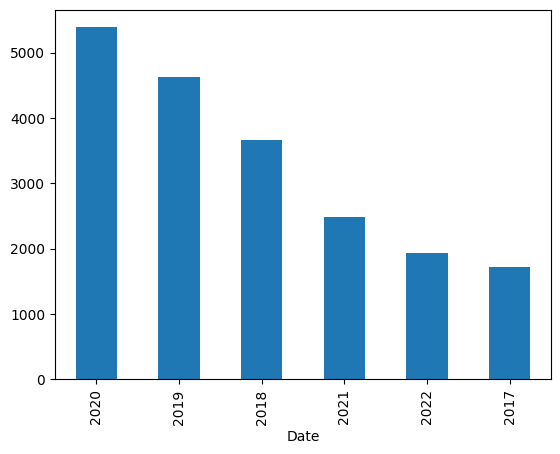

In [ ]:
df_analisis['Date'] = pd.to_datetime(df_analisis['Date'])
df_analisis['Date'].dt.year.value_counts().plot(kind='bar')

### **Cantidad de tweets por año**

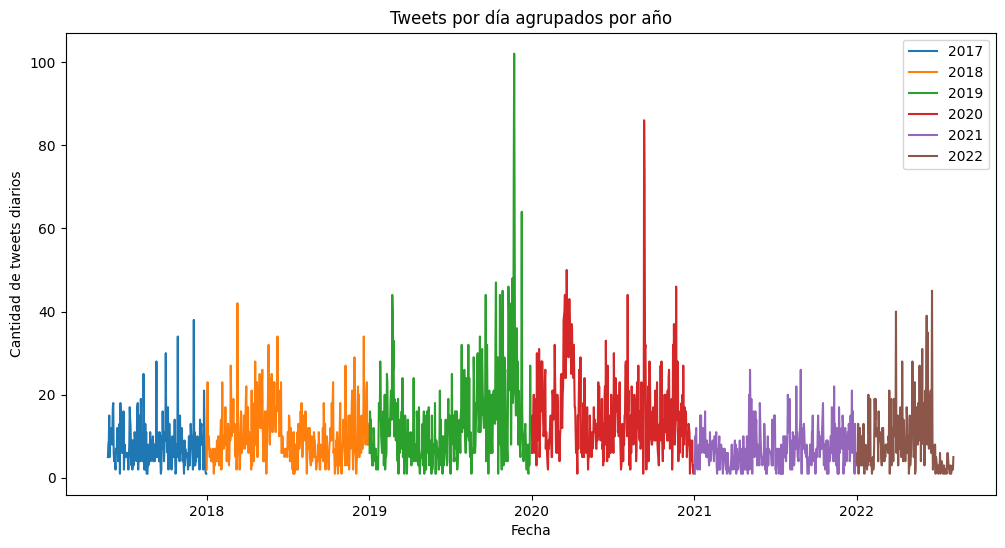

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

for year, group in df.groupby(df_analisis['Date'].dt.year):
    group.groupby(group['Date'].dt.date).size().plot(ax=ax, label=year)

plt.title("Tweets por día agrupados por año")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de tweets diarios")
plt.legend()
plt.show()


### **Comportamiento Dia y Hora frecuencia de publicacion**

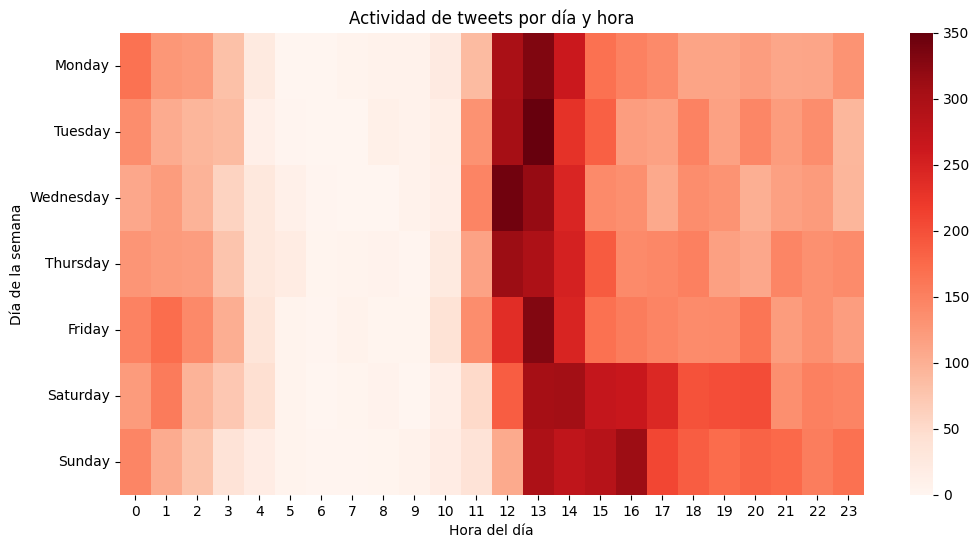

In [ ]:
import seaborn as sns

actividad = df.groupby([df_analisis['Date'].dt.day_name(), df['Date'].dt.hour]).size().unstack(fill_value=0)

actividad = actividad.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.figure(figsize=(12,6))
sns.heatmap(actividad, cmap='Reds')
plt.title("Actividad de tweets por día y hora")
plt.xlabel("Hora del día")
plt.ylabel("Día de la semana")
plt.show()


### **Limpieza Stop Words**

In [ ]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')

def eliminar_stop_words(text):
    stop_words = set(nltk.corpus.stopwords.words('spanish'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df_analisis['clean_tweet'] = df_analisis['clean_tweet'].apply(eliminar_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Top palabras segun unicamente frecuencia**

In [ ]:
from collections import Counter

tokens = [word for tweet in df_analisis['clean_tweet'] for word in tweet.split()]

frecuencias = Counter(tokens)

top_10 = frecuencias.most_common(10)
print("Top 10 palabras más frecuentes:")
for palabra, freq in top_10:
    print(f"{palabra}: {freq}")


Top 10 palabras más frecuentes:
colombia: 4586
bogotá: 2332
si: 2290
humana: 1996
duque: 1604
solo: 1393
gobierno: 1362
debe: 1276
paz: 1228
hoy: 1210


### **Wordcloud**

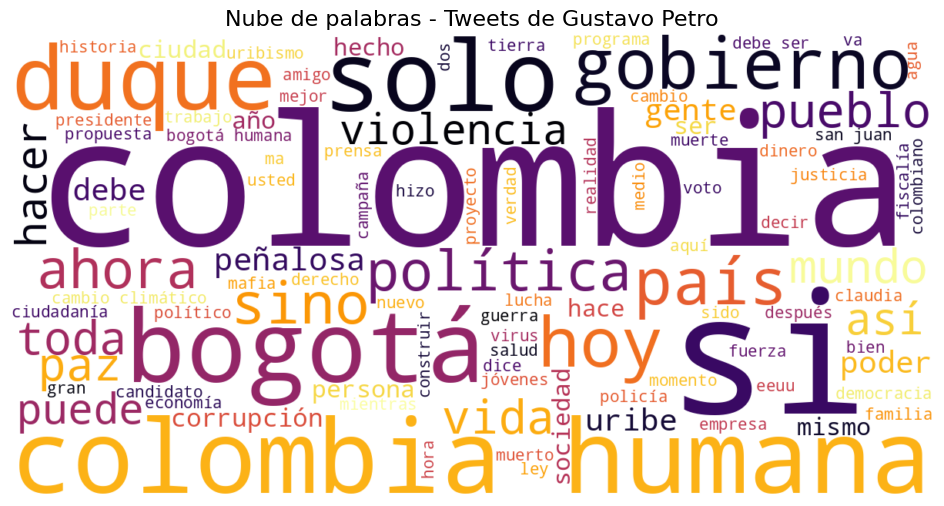

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='inferno',
    max_words=100
).generate(" ".join(tokens))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Tweets de Gustavo Petro", fontsize=16)
plt.show()


## **Preprocesamiento para TF-IDF (limpio y lematizado)**

In [ ]:
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])

def limpiar_y_lematizar(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", texto)
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    doc = nlp(texto)
    lemas = [tok.lemma_ for tok in doc if not tok.is_stop and len(tok) > 2]
    return " ".join(lemas)

df_tfidf = df_base.copy()
df_tfidf['clean_text'] = df_tfidf['Tweet'].apply(limpiar_y_lematizar)

# Etiqueta binaria de ejemplo (para clasificación)
df_tfidf['label'] = np.random.randint(0, 2, len(df_tfidf))

print("Dataset TF-IDF listo. Ejemplo:")
df_tfidf[['Tweet', 'clean_text']].head()


Dataset TF-IDF listo. Ejemplo:


,Tweet,clean_text
0,La prensa engolosinada con el dinero público q...,prensa engolosinado dinero público mano lleno ...
1,Se vuelve ley el regalo de fin de año a los ma...,volver ley regalo año rico país dueño petroler...
2,"Continua la danza macabra, la orgía de sangre.",continuo danza macabrir orgía sangre
3,El gobierno progresista de España a punto de c...,gobierno progresista españa punto conformar él...
4,El gobierno progresista de España a punto de c...,gobierno progresista españa punto conformar él...


## Preprocesamiento para Modelo de Markov (Casi intacto el texto)

In [ ]:
def limpieza_markov(texto):
    texto = re.sub(r"http\S+|www\S+|@\w+", "", texto)  # solo URLs y menciones
    texto = texto.replace("\n", " ").strip()
    return texto

df_markov = df_base.copy()
df_markov['markov_text'] = df_markov['Tweet'].apply(limpieza_markov)

print("Dataset Markov listo. Ejemplo:")
df_markov[['Tweet', 'markov_text']].head()


Dataset Markov listo. Ejemplo:


,Tweet,markov_text
0,La prensa engolosinada con el dinero público q...,La prensa engolosinada con el dinero público q...
1,Se vuelve ley el regalo de fin de año a los ma...,Se vuelve ley el regalo de fin de año a los ma...
2,"Continua la danza macabra, la orgía de sangre.","Continua la danza macabra, la orgía de sangre."
3,El gobierno progresista de España a punto de c...,El gobierno progresista de España a punto de c...
4,El gobierno progresista de España a punto de c...,El gobierno progresista de España a punto de c...


## Preprocesamiento para Red Neuronal

In [ ]:
def limpieza_neuronal(texto):
    # Mantiene hashtags, emojis, puntuación (solo elimina URLs y menciones)
    texto = re.sub(r"http\S+|www\S+|@\w+", "", texto)
    texto = unidecode(texto)  # normaliza acentos sin perder estilo
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

df_lstm = df_base.copy()
df_lstm['nn_text'] = df_lstm['Tweet'].apply(limpieza_neuronal)

print("Dataset LSTM listo. Ejemplo:")
df_lstm[['Tweet', 'nn_text']].head()


Dataset LSTM listo. Ejemplo:


,Tweet,nn_text
0,La prensa engolosinada con el dinero público q...,La prensa engolosinada con el dinero publico q...
1,Se vuelve ley el regalo de fin de año a los ma...,Se vuelve ley el regalo de fin de ano a los ma...
2,"Continua la danza macabra, la orgía de sangre.","Continua la danza macabra, la orgia de sangre."
3,El gobierno progresista de España a punto de c...,El gobierno progresista de Espana a punto de c...
4,El gobierno progresista de España a punto de c...,El gobierno progresista de Espana a punto de c...


# 3. EXTRACCIÓN DE CARACTERÍSTICAS (Visualizacion) / VECTORIZACIÓN


## 3.1 Implementación de Estrategia de Extracción de Características

### A. Estrategia 1: TF-IDF (Para Análisis Descriptivo/Temático)

* **Modelo:** `TfidfVectorizer` (aplicado sobre el texto **Lematizado**).
* **Función:** Convierte el texto lematizado en una matriz numérica dispersa ponderada. Se usa para identificar la **importancia relativa** de cada término en el corpus.

### B. Estrategia 2: Secuenciación (Para Generación Avanzada)

* **Modelo:** `Tokenizer` + `pad_sequences` (aplicado sobre el texto **LSTM Neuronal**).
* **Función:** Convierte las palabras en secuencias de índices numéricos de longitud uniforme, creando la matriz de entrada para la red neuronal.


## 3.2 Detección de Temas No Supervisada

* **Objetivo:** Usar la representación **TF-IDF** para descubrir los ejes temáticos principales del corpus.
* **Técnica:** **Latent Dirichlet Allocation (LDA)**, aplicado directamente sobre la matriz TF-IDF. Esto clasifica las *features* lematizadas más distintivas en un número fijo de temas, cumpliendo con la **extracción avanzada de características**.

## VECTORIZACIÓN TF-IDF (Para Visualizacion)

In [ ]:
# Función: Convierte texto lematizado en una matriz numérica dispersa ponderada.
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

# Datos para Clasificación Supervisada
X_tfidf = tfidf_vectorizer.fit_transform(df_tfidf['clean_text'])
y_tfidf = df_tfidf['label']

# División para Modelos Clásicos
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.2, random_state=42, stratify=y_tfidf
)

print(f"Vectorización TF-IDF lista. Shape de entrenamiento: {X_train_tfidf.shape}")


Vectorización TF-IDF lista. Shape de entrenamiento: (15832, 10000)


## SECUENCIACIÓN (Para Redes Neuronales)

In [ ]:
# Función: Convierte texto mínimamente limpio en secuencias de índices numéricos de longitud uniforme.
MAX_WORDS = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(df_lstm['nn_text'])
sequences = tokenizer.texts_to_sequences(df_lstm['nn_text'])
X_lstm = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y_lstm = df_tfidf['label']

# División para Modelos LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm
)

print(f"Secuenciación LSTM lista. Shape de entrenamiento: {X_train_lstm.shape}")

Secuenciación LSTM lista. Shape de entrenamiento: (15832, 50)


## Análisis y Visualización de Palabras Clave

In [ ]:
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calcular la suma del peso TF-IDF por cada palabra a través de todos los tweets
sums_tfidf = X_tfidf.sum(axis=0)

# Crear un DataFrame para un análisis fácil
df_tfidf_scores = pd.DataFrame(sums_tfidf.T, index=feature_names, columns=["tfidf_score"])
df_tfidf_scores = df_tfidf_scores.sort_values(by="tfidf_score", ascending=False)

# Mostrar el Top 25 de palabras/bigramas clave
print("--- Top 25 Palabras/Bigramas Clave (Lematizados por TF-IDF Score) ---")
print(df_tfidf_scores.head(25))

--- Top 25 Palabras/Bigramas Clave (Lematizados por TF-IDF Score) ---
                 tfidf_score
colombia          462.753080
humano            287.630514
bogotá            282.184673
él                250.977897
colombia humano   222.887086
duque             203.217204
gobierno          198.930005
paz               181.166231
cambio            175.749290
social            173.087846
público           170.730029
país              162.201287
vida              159.453080
pueblo            144.852593
política          138.943758
colombiano        138.381610
político          133.207753
sociedad          130.901711
metro             128.150799
justicia          124.724761
salud             122.974719
millón            118.207913
año               111.459331
democracia        110.807718
derecho           110.583352


## Visualización: Gráfico de Barras de Top Palabras

/tmp/ipython-input-1288059895.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_tfidf['tfidf_score'], y=top_20_tfidf.index, palette="rocket")


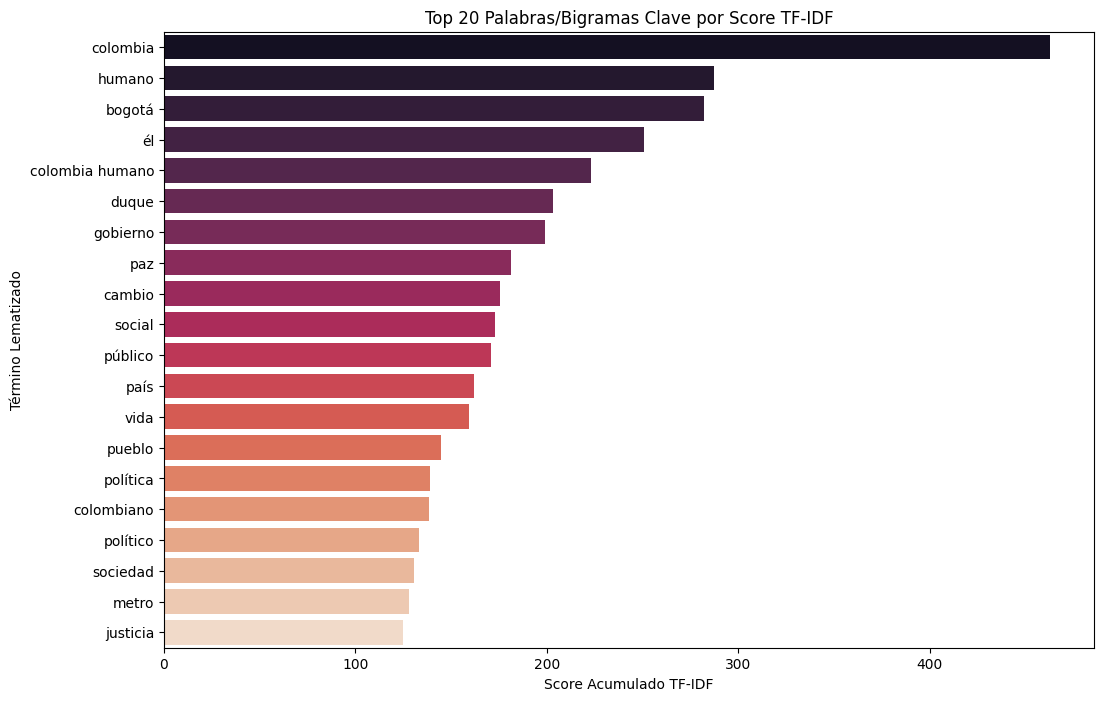

In [ ]:
# Graficar el Top 20
top_20_tfidf = df_tfidf_scores.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_tfidf['tfidf_score'], y=top_20_tfidf.index, palette="rocket")
plt.title('Top 20 Palabras/Bigramas Clave por Score TF-IDF')
plt.xlabel('Score Acumulado TF-IDF')
plt.ylabel('Término Lematizado')
plt.show()

## Detección de Temas

In [ ]:
# Parámetros
N_TEMAS = 6 # Número de temas a descubrir. Puedes ajustarlo.
N_TOP_WORDS = 1 # Número de palabras más influyentes por tema.

lda = LatentDirichletAllocation(
    n_components=N_TEMAS,
    max_iter=40, # Bajas iteraciones para prueba
    learning_method='batch',
    random_state=42,
    n_jobs=-1 # Usar todos los cores disponibles
)
lda.fit(X_tfidf)

# Función para imprimir los resultados de LDA
def mostrar_top_palabras_por_tema(model, feature_names, n_top_words):
    """Muestra las palabras más influyentes para cada tema LDA."""
    print(f"\n--- Temas identificados (Top {n_top_words} palabras lematizadas) ---")
    for topic_idx, topic in enumerate(model.components_):
        # Obtener los índices de las n_top_words con mayor peso para este tema
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]

        # Asignar un nombre descriptivo basado en las palabras clave (requiere interpretación)
        nombre_tema = f"Tema {topic_idx+1}"

        print(f"{nombre_tema}: {' '.join(top_features)}")

# Ejecución de la visualización de temas
mostrar_top_palabras_por_tema(lda, feature_names, N_TOP_WORDS)


--- Temas identificados (Top 1 palabras lematizadas) ---
Tema 1: metro
Tema 2: salud
Tema 3: duque
Tema 4: colombia
Tema 5: fiscal
Tema 6: colombia



# 4. Modelo de Generación de Texto (Objetivo Principal)




## 4.1 Generación *Baseline*

* **Modelo:** Cadenas de **Markov** (N-gramas de palabras).

In [ ]:
def entrenar_modelo_markov(corpus, orden=2):
    """Crea el diccionario de transiciones de Markov."""
    modelo = defaultdict(list)

    # Unir todos los tweets en un solo texto y tokenizar por palabras
    texto_completo = " ".join(corpus).split()

    # Crear la ventana de N-gramas (orden)
    for i in range(len(texto_completo) - orden):
        # La 'clave' es el estado actual (N palabras)
        clave = tuple(texto_completo[i:i + orden])
        # El 'valor' es la siguiente palabra posible
        siguiente = texto_completo[i + orden]
        modelo[clave].append(siguiente)

    return modelo

def generar_tweet_markov(modelo, longitud_max=30):
    """Genera un nuevo tweet a partir del modelo entrenado."""

    # Obtener todas las claves (inicios de frase)
    claves = list(modelo.keys())

    # Elegir un inicio de frase al azar
    if not claves:
        return "Error: Corpus muy pequeño o modelo vacío."

    inicio = random.choice(claves)
    tweet_generado = list(inicio)

    for _ in range(longitud_max - len(inicio)):
        estado_actual = tuple(tweet_generado[-len(inicio):])

        if estado_actual in modelo:
            # Elegir aleatoriamente la siguiente palabra
            siguiente_palabra = random.choice(modelo[estado_actual])
            tweet_generado.append(siguiente_palabra)
        else:
            # Detener si no hay transiciones posibles
            break

    return " ".join(tweet_generado).strip()

print("--- Generación con Cadenas de Markov (Orden 2) ---")

# Entrenar con los datos de limpieza mínima
markov_model = entrenar_modelo_markov(df_markov['markov_text'].tolist(), orden=2)

for i in range(1, 4):
    tweet = generar_tweet_markov(markov_model, longitud_max=30)
    print(f"Tweet {i}: {tweet}")

--- Generación con Cadenas de Markov (Orden 2) ---
Tweet 1: sobre tributación y garantías laborales en corferias porque demostraron un megaderroche incentivado por y y la banda la Cordillera nos apareció un pariente tan querido para él. Mi sentido pésame
Tweet 2: idea central del país y miles de personas en estos días el máximo consenso para hacer el dialogo los venezolanos deben solucionar por el sistema de educación publico puede ser
Tweet 3: Caribe colombiano. El movimiento estudiantil esperar toma de posición politica y la ignorancia para ocultar la propia oposición en el gobierno colombiano para el caso de Bogotá, que llevaba la


### **Pruebas con diferentes gramas**

In [ ]:
markov_model_5 = entrenar_modelo_markov(df_markov['markov_text'].tolist(), orden=5)

for i in range(1, 4):
    tweet = generar_tweet_markov(markov_model_5, longitud_max=30)
    print(f"Tweet {i}: {tweet}")

Tweet 1: atención de la emergencia vital no es un problema de liquidez de los bancos sino del Estado y las familias e individuos. Duque equivoca los propósitos de la emergencia Le
Tweet 2: referendos hoy se silencien ante la adjudicación corrupta de obra mas grande de la historia de Colombia Plazoleta San Francisco, Popayán con el Pacto Histórico. Preparando el encuentro del Pacto
Tweet 3: Gaviria recupere la línea de "La Revolución en Marcha" de Lopez Pumarejo, se deban continuar hoy en Colombia, precisamente para construir la Paz. Al estilo de Daniel Coronell esta señora


In [ ]:
markov_model_8 = entrenar_modelo_markov(df_markov['markov_text'].tolist(), orden=8)

for i in range(1, 4):
    tweet = generar_tweet_markov(markov_model_8, longitud_max=30)
    print(f"Tweet {i}: {tweet}")

Tweet 1: histórico abre el camino de la esperanza de una democracia multicolor. Hay quienes hoy se proponen como fuerza transformadora después de estar en los últimos gobiernos durante 20 años en
Tweet 2: derrotar ese fascismo o él derrotará a Colombia. Uribe dijo que el problema de la educación era fecode, cuando el mismo le quito los recursos públicos a la educación. Creen
Tweet 3: modelo del uribismo o del uribismo sin Uribe, eso debe ser claro para las autedenominadas izquierdas, derechas y centro Desde la campaña presidencial y en medio de ella me investigaban


In [ ]:
markov_model_10 = entrenar_modelo_markov(df_markov['markov_text'].tolist(), orden=10)

for i in range(1, 4):
    tweet = generar_tweet_markov(markov_model_10, longitud_max=50)
    print(f"Tweet {i}: {tweet}")

Tweet 1: presidente del Senado. En Colombia se desarrolla una operacion real contra la Paz Pensé que era en Colombia. Ayer dilataron con las peores argucias filibusteras la votación de las objeciones presidenciales en Senado. Se desarrolla un golpe de Estado contra la Justicia y la Paz y es en Colombia. Todo
Tweet 2: que se pone fuera de la ley El gobierno en su deriva dictatorial se apresta a decretar la conmoción interior. Mi rechazo total a ese camino Propongo en cambio hacer el dialogo con el comité de paro ampliado con delegados de las movilizaciones ya. Mientras se dialoga establecer una tregua
Tweet 3: de la paz y el final definitivo de la insurgencia armada Fundamental en la transición del país hacia una democracia moderna y justa con la gente. Casi toda la población colombiana terminará infectada por el covid, morirá gente vulnerable no vacunada. Esas muertes solo serán el producto de una distribución


In [ ]:
tweet = df_base.loc[
    df_base['Tweet'].str.contains("atención de la emergencia vital no es un problema de liquidez de los bancos sino del Estado y las familias e individuos", case=False, na=False),
    'Tweet'
].values[0]

print(tweet)

Roy tiene razón .

Pero hay un problema mayor. La atención de la emergencia vital no es un problema de liquidez de los bancos sino del Estado y las familias e individuos.

Duque equivoca los propósitos de la emergencia


## 4.2 Generación Avanzada

* **Modelo:** Red Neuronal Recurrente **(LSTM)** con predicción de la siguiente palabra.

In [ ]:
# --- PARÁMETROS ---
MAX_LEN = 50       # Máxima longitud de tweet (truncado/padding)
SAMPLE_SIZE = 10000 # Usar una muestra de 10000 tweets para entrenar
EMBEDDING_DIM = 100 # Dimensión del vector de embedding
LSTM_UNITS = 150    # Unidades en la capa LSTM


# Definir el corpus de MUESTRA para generar secuencias
corpus_sample = df_lstm['nn_text'].sample(n=SAMPLE_SIZE, random_state=42).tolist()

# Ajustar el Tokenizer al CORPUS COMPLETO (para tener el mapeo completo)
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(df_lstm['nn_text'])
VOCAB_SIZE = len(tokenizer.word_index) + 1

# Creación de secuencias (N-gramas de palabras) solo en la MUESTRA
input_sequences = []
for tweet in corpus_sample:
    token_list = tokenizer.texts_to_sequences([tweet])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Padding y división de X e Y
max_sequence_len = max([len(x) for x in input_sequences])
padded_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

X_seq = padded_sequences[:, :-1]
# y_seq se mantiene como índices enteros (usamos sparse_categorical_crossentropy)
y_seq = padded_sequences[:, -1]

print(f"Número de secuencias de entrenamiento: {X_seq.shape[0]:,}")
print(f"Longitud máxima de la secuencia: {max_sequence_len}")
print(f"Tamaño del vocabulario (VOCAB_SIZE): {VOCAB_SIZE:,}")

# --- CREACIÓN Y ENTRENAMIENTO DEL MODELO LSTM ---

def crear_modelo_lstm_generativo(vocab_size, embedding_dim, lstm_units):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        LSTM(lstm_units),
        Dense(vocab_size, activation='softmax')
    ])
    # sparse_categorical_crossentropy para ahorrar RAM
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = crear_modelo_lstm_generativo(VOCAB_SIZE, EMBEDDING_DIM, LSTM_UNITS)
print(f"\nModelo creado con función de pérdida 'sparse_categorical_crossentropy'.")

print("\n--- 2. Entrenando Modelo LSTM ---")

history = lstm_model.fit(X_seq, y_seq, epochs=20, verbose=1, batch_size=128)


# --- FUNCIÓN DE GENERACIÓN LSTM  ---

def generar_tweet_lstm(modelo, tokenizer, seed_text, next_words, max_seq_len, temperature=0.7):#Temperatura por defecto


    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')

        # Obtener las probabilidades (vector de salida)
        preds = modelo.predict(token_list, verbose=0)[0]


        # Esto aumenta la probabilidad de las palabras menos probables.
        preds = np.asarray(preds).astype('float64')

        # Evitamos log(0) añadiendo 1e-7
        preds = np.log(preds + 1e-7) / temperature
        exp_preds = np.exp(preds)

        # Normalizar para que sume 1
        preds = exp_preds / np.sum(exp_preds)

        # np.random.multinomial elige aleatoriamente un índice basado en las probabilidades
        predicted_index = np.argmax(np.random.multinomial(1, preds, 1))

        # Mapear el índice a palabra
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        # Detener si se genera la palabra desconocida o si no hay palabra
        if output_word == "" or output_word == '<unk>':
            break

        seed_text += " " + output_word

    return seed_text



Número de secuencias de entrenamiento: 309,787
Longitud máxima de la secuencia: 58
Tamaño del vocabulario (VOCAB_SIZE): 28,347

Modelo creado con función de pérdida 'sparse_categorical_crossentropy'.

--- 2. Entrenando Modelo LSTM ---
Epoch 1/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.0898 - loss: 6.9350
Epoch 2/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.1374 - loss: 5.8389
Epoch 3/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.1610 - loss: 5.4243
Epoch 4/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.1812 - loss: 5.0881
Epoch 5/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.1973 - loss: 4.7872
Epoch 6/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.2130 - loss: 4.5345
Epoch 7/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.2252 - loss: 4.3035
Epoch 8/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.2381 - loss: 4.1045
Epoch 9/20
2421/2421 ━━━━━━━━━━━━━━━━━━━━ 44s

## Experimentación y Comparación
Cambiar el valor de la variable Temperature, cambia los valores de probabilidades para elegir la siguiente palabra buscando evitar los bucles de palabras

In [ ]:
# --- GENERACIÓN DE EXPERIMENTACION ---
print("\n--- 3. Generación con LSTM (Sampling) ---")
seed = "mujeres"
generated_tweet = generar_tweet_lstm(
    modelo=lstm_model,
    tokenizer=tokenizer,
    seed_text=seed,
    next_words=20,
    max_seq_len=max_sequence_len,
    temperature=0.4 #Modificar
)
print(f"Semilla: '{seed}'")
print(f"Tweet Generado: {generated_tweet}")


--- 3. Generación con LSTM (Sampling) ---
Semilla: 'mujeres'
Tweet Generado: mujeres negras estallido de la colombia humana y que no se puede construir la paz en colombia no es cierto que
